# Example of train with a KeypointRCNN_ResNet50_FPN pre-trained model

In the code below, we are going to use the KeypointRCNN_ResNet50_FPN_Weights model pre-trained on the COCO dataset to train on our own dataset.

Import libraries

In [65]:
import json
import os
import cv2
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import kornia as K
import matplotlib.pyplot as plt
import torchvision
from torchvision.models.detection import KeypointRCNN_ResNet50_FPN_Weights
from tqdm import tqdm
import torch.optim as optim
from tqdm import tqdm
import datetime
import os


In [66]:
class CustomDataset(Dataset):
    def __init__(self, images_path, annotations_path, use_augmentation, device):
        self.images_path = images_path
        self.annotations_path = annotations_path
        self.device = device
        self.image_filenames = [filename for filename in os.listdir(images_path) if filename.endswith('.jpg')]

        if use_augmentation:
            # Declare an augmentation pipeline
            self.transform =K.augmentation.AugmentationSequential(
                K.augmentation.RandomVerticalFlip(), 
                K.augmentation.RandomHorizontalFlip(),
                K.augmentation.RandomRotation(30),
                K.augmentation.RandomBrightness(0.5, 1.5),
                K.augmentation.RandomContrast(0.5, 1.5),
                data_keys=["input", "bbox", "keypoints"])
        else:
            self.transform = K.augmentation.AugmentationSequential(
                K.augmentation.RandomRotation(0),
                data_keys=["input", "bbox", "keypoints"])

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):

        image_filename = self.image_filenames[idx]
        image_tensor = self.load_image(os.path.join(self.images_path, image_filename))
        annotation_filename = os.path.join(self.annotations_path, image_filename[:-4] + '.json')

        with open(annotation_filename, 'r') as f:
            bbox_tensor, keypoint_tensor = self.convert_to_kornia_format(json.load(f))
    
        out_tensor = self.transform(image_tensor.float(), bbox_tensor.float(), keypoint_tensor.float())
        
        # plot augmentation to test it
        if False:
            img_out = self.plot_resulting_image(
            out_tensor[0][0],
            out_tensor[1].int(),
            out_tensor[2].int(),
            )
            # plot the image
            plt.imshow(K.tensor_to_image(image_tensor.mul(255).byte()).copy())
            plt.show()
            plt.imshow(img_out)
            plt.show()

        # get the torch format from kornia format
        target = self.kornia_to_torch_format( out_tensor[1], out_tensor[2])

        # return tensors
        return image_tensor, target

    def load_image(self, image_path: str)-> torch.Tensor:
        """
        Method to load image
        params:
            image_path: str = path of the image
        return:
            tensor: torch.Tensor = image tensor
        """

        # load image and convert to tensor
        image: np.ndarray = cv2.imread(image_path)

        # convert to tensor
        image_tensor: torch.Tensor = K.image_to_tensor(image)

        # bgr to rgb
        image_tensor = K.color.bgr_to_rgb(image_tensor)

        return K.enhance.normalize(image_tensor, torch.tensor(0.), torch.tensor(255.)).to(self.device)
    
    def convert_to_kornia_format(self, data):
        """
        Method to convert the bounding boxes and keypoints to the Kornia format
        params:
            data: dict = dictionary containing the bounding boxes and keypoints
        return:
            bbox_tensor: torch.Tensor = tensor containing the bounding boxes
            keypoint_tensor: torch.Tensor = tensor containing the keypoints
        """

        # Extract the bounding boxes and keypoints from the dictionary
        bboxes = data['bboxes']
        keypoints = data['keypoints']

        # Convert the bounding boxes to the Kornia format
        bbox_list = []
        for bbox in bboxes:
            x1, y1, x2, y2 = bbox
            bbox_list.append([[x1, y1], [x2, y1], [x2, y2], [x1, y2]])
        bbox_tensor = torch.tensor(bbox_list).unsqueeze(0).to(self.device)

        # Convert the keypoints to the Kornia format
        keypoint_list = []
        for kpts in keypoints:
            for kpt in kpts:
                x, y, _ = kpt
                keypoint_list.append([x, y])
        keypoint_tensor = torch.tensor(keypoint_list).unsqueeze(0).to(self.device)
        return bbox_tensor, keypoint_tensor
    
    def plot_resulting_image(self, img, bbox, keypoints):
        """
        Plot the resulting image with bounding boxes and keypoints.
        params:
            img: torch.Tensor = image tensor
            bbox: torch.Tensor = bounding box tensor
            keypoints: torch.Tensor = keypoints tensor
        return:
            img_draw = image with bounding boxes and keypoints
        """
        img_array = K.tensor_to_image(img.mul(255).byte()).copy()
        img_draw = cv2.polylines(img_array, bbox.reshape(-1, 4, 2).cpu().numpy(), isClosed=True, color=(255, 0, 0))
        for k in keypoints[0]:
            img_draw = cv2.circle(img_draw, tuple(k.cpu().numpy()[:2]), radius=6, color=(255, 0, 0), thickness=-1)
        return img_draw

    def kornia_to_torch_format(self, bbox_tensor, keypoint_tensor, labels=None):
        """
        Convert bbox_tensor and keypoint_tensor in Kornia format to torch's expected format.
        
        Parameters:
        - bbox_tensor (torch.Tensor): Bounding box tensor in Kornia format
        - keypoint_tensor (torch.Tensor): Keypoint tensor in Kornia format
        - labels (list[int]): List of class labels for each bounding box. If None, default to label=1 for all boxes.
        
        Returns:
        - dict: A dictionary with 'boxes', 'labels', and 'keypoints' in the format expected by torch.
        """
        # Convert bbox_tensor from Kornia's format to torch's [x1, y1, x2, y2] format
        boxes = torch.stack([bbox_tensor[0,:,0,0], bbox_tensor[0,:,0,1], bbox_tensor[0,:,2,0], bbox_tensor[0,:,2,1]], dim=1)
        
        # If labels aren't provided, assume a default label of 1 for all bounding boxes
        if labels is None:
            labels = torch.ones((bbox_tensor.shape[1],), dtype=torch.int64).to(self.device)
        else:
            labels = torch.tensor(labels, dtype=torch.int64).to(self.device)
        
        # Convert keypoint_tensor to the desired [x, y, visibility] format
        keypoints = torch.zeros((bbox_tensor.shape[1], keypoint_tensor.shape[1]//bbox_tensor.shape[1], 3)).to(self.device)
        for i in range(bbox_tensor.shape[1]):
            keypoints[i, :, :2] = keypoint_tensor[0, i*2:(i+1)*2, :]
            keypoints[i, :, 2] = 1  # setting visibility to 1
        
        return {"boxes": boxes, "labels": labels, "keypoints": keypoints}

def collate_fn(batch):
    """
    Collate function to format the batch in the desired manner.
    
    Parameters:
    - batch (list): List of tuples where each tuple contains an image tensor and its associated target.
    
    Returns:
    - tuple: Tuple containing a tensor of images and a list of targets.
    """
    # Separate images and targets in the batch
    images, targets = zip(*batch)
    
    return images, targets


# if cuda is avaliable, use it
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

train_images_path = 'dataset/train/images'
train_annotations_path = 'dataset/train/annotations'
test_images_path = 'dataset/test/images'
test_annotations_path = 'dataset/test/annotations'

train_dataset = CustomDataset(train_images_path, train_annotations_path,use_augmentation = True, device = device)
test_dataset = CustomDataset(test_images_path, test_annotations_path,  use_augmentation = False, device = device)

train_dataloader = DataLoader(train_dataset, batch_size = 16, shuffle=True, collate_fn=collate_fn)
test_dataloader = DataLoader(test_dataset, batch_size = 8, shuffle=False, collate_fn=collate_fn)

# Get a batch of images and annotations from the train dataloader
images, targets = next(iter(train_dataloader))

print(len(images))
print(len(targets))

cuda
16
16


# TRAIN

In [67]:
model = torchvision.models.detection.keypointrcnn_resnet50_fpn(pretrained=False,
                                                                   pretrained_backbone=True,
                                                                   num_keypoints=2,
                                                                   num_classes = 2)
model.to(device).train()
print(model)

/home/sorb/projects/multi_model_keypoint_detection/venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/sorb/projects/multi_model_keypoint_detection/venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/home/sorb/projects/multi_model_keypoint_detection/venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained_backbone' is deprecated since 0.13 and may be removed in the future, please use 'weights_backbone' instead.
  warnings.warn(
/home/sorb/projects/multi_model_keypoint_detection/venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223:

KeypointRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(640, 672, 704, 736, 768, 800), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, 

In [68]:
# Define some hyperparameters
num_epochs = 100
lr = 0.001

# Create a directory with the current timestamp
now = datetime.datetime.now()
timestamp = now.strftime('%Y-%m-%d_%H-%M-%S')
save_dir = os.path.join("saved_models", timestamp)
os.makedirs(save_dir, exist_ok=True)

# select parameters to finetune
params = [p for p in model.parameters() if p.requires_grad]

# Define the optimizer
# optimizer = optim.Adam(params, lr=lr)
optimizer = torch.optim.SGD(params, lr=0.001, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.3)

best_loss = float('inf')  # Initialize with a high value

# Training loop
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    
    model.train()  # Set model to training mode
    
    running_loss = 0.0
    for images, targets in tqdm(train_dataloader):
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        loss_dict = model(images, targets)
        
        # Compute total loss
        losses = sum(loss for loss in loss_dict.values())
        
        # Backward pass and optimize
        losses.backward()
        optimizer.step()
        lr_scheduler.step()
        
        # Print statistics
        running_loss += losses.item()

    # Validation phase
    val_loss = 0.0
    
    with torch.no_grad():
        for images, targets in tqdm(test_dataloader):

            # Forward pass
            loss_dict = model(images, targets)
            
            # Compute total loss
            losses = sum(loss for loss in loss_dict.values())

            # Accumulate validation loss
            val_loss += losses.item()
            

    # Compute average loss for the epoch
    avg_train_loss = running_loss / len(train_dataloader)
    print(f"Training Loss: {avg_train_loss}")

    # Compute average validation loss for the epoch
    avg_val_loss = val_loss / len(test_dataloader)
    print(f"Validation Loss: {avg_val_loss}")

    # Save the model if the validation loss improved
    if avg_val_loss < best_loss:
        best_loss = avg_val_loss
        print(f"Improved validation loss at epoch {epoch+1}. Saving model...")
        torch.save(model.state_dict(), os.path.join(save_dir, f"model_best_epoch_{epoch+1}.pth"))
    
    # empty cuda cache
    torch.cuda.empty_cache()

print('Finished Training')


Epoch 1/100


100%|██████████| 3/3 [00:01<00:00,  2.02it/s]


Training Loss: 18.8169070652553
Validation Loss: 8.252510706583658
Improved validation loss at epoch 1. Saving model...
Epoch 2/100


100%|██████████| 3/3 [00:01<00:00,  1.98it/s]


Training Loss: 8.228113174438477
Validation Loss: 8.12425454457601
Improved validation loss at epoch 2. Saving model...
Epoch 3/100


100%|██████████| 3/3 [00:01<00:00,  1.97it/s]


Training Loss: 8.161018371582031
Validation Loss: 8.060397148132324
Improved validation loss at epoch 3. Saving model...
Epoch 4/100


100%|██████████| 3/3 [00:01<00:00,  2.02it/s]


Training Loss: 8.129038674490792
Validation Loss: 8.045127232869467
Improved validation loss at epoch 4. Saving model...
Epoch 5/100


100%|██████████| 3/3 [00:01<00:00,  2.00it/s]


Training Loss: 8.111178943089076
Validation Loss: 8.03645372390747
Improved validation loss at epoch 5. Saving model...
Epoch 6/100


100%|██████████| 3/3 [00:01<00:00,  2.03it/s]


Training Loss: 8.117535999843053
Validation Loss: 7.984595934549968
Improved validation loss at epoch 6. Saving model...
Epoch 7/100


100%|██████████| 3/3 [00:01<00:00,  2.02it/s]


Training Loss: 8.139726638793945
Validation Loss: 8.001631259918213
Epoch 8/100


100%|██████████| 3/3 [00:01<00:00,  2.02it/s]


Training Loss: 8.130216326032366
Validation Loss: 8.037124633789062
Epoch 9/100


100%|██████████| 3/3 [00:01<00:00,  2.01it/s]


Training Loss: 8.096522467476982
Validation Loss: 8.058019161224365
Epoch 10/100


100%|██████████| 3/3 [00:01<00:00,  2.00it/s]


Training Loss: 8.142434256417411
Validation Loss: 8.01856517791748
Epoch 11/100


100%|██████████| 3/3 [00:01<00:00,  2.01it/s]


Training Loss: 8.113694190979004
Validation Loss: 8.00320291519165
Epoch 12/100


100%|██████████| 3/3 [00:01<00:00,  1.98it/s]


Training Loss: 8.088689531598773
Validation Loss: 8.01830275853475
Epoch 13/100


100%|██████████| 3/3 [00:01<00:00,  1.98it/s]


Training Loss: 8.123494148254395
Validation Loss: 8.051843961079916
Epoch 14/100


100%|██████████| 3/3 [00:01<00:00,  1.96it/s]


Training Loss: 8.132243428911481
Validation Loss: 8.032611846923828
Epoch 15/100


100%|██████████| 3/3 [00:01<00:00,  1.97it/s]


Training Loss: 8.11491094316755
Validation Loss: 7.9545572598775225
Improved validation loss at epoch 15. Saving model...
Epoch 16/100


100%|██████████| 3/3 [00:01<00:00,  2.01it/s]


Training Loss: 8.10125800541469
Validation Loss: 8.016090075174967
Epoch 17/100


100%|██████████| 3/3 [00:01<00:00,  2.04it/s]


Training Loss: 8.137000152042933
Validation Loss: 8.055747509002686
Epoch 18/100


100%|██████████| 3/3 [00:01<00:00,  1.99it/s]


Training Loss: 8.114581653050013
Validation Loss: 7.983754475911458
Epoch 19/100


100%|██████████| 3/3 [00:01<00:00,  2.01it/s]


Training Loss: 8.154396602085658
Validation Loss: 8.019099235534668
Epoch 20/100


100%|██████████| 3/3 [00:01<00:00,  2.01it/s]


Training Loss: 8.152530125209264
Validation Loss: 8.02754577000936
Epoch 21/100


100%|██████████| 3/3 [00:01<00:00,  2.03it/s]


Training Loss: 8.13905130113874
Validation Loss: 8.018320719401041
Epoch 22/100


100%|██████████| 3/3 [00:01<00:00,  2.04it/s]


Training Loss: 8.136007036481585
Validation Loss: 8.00413735707601
Epoch 23/100


100%|██████████| 3/3 [00:01<00:00,  2.01it/s]


Training Loss: 8.106035096304756
Validation Loss: 8.00477409362793
Epoch 24/100


100%|██████████| 3/3 [00:01<00:00,  1.96it/s]


Training Loss: 8.12233488900321
Validation Loss: 8.018157800038656
Epoch 25/100


100%|██████████| 3/3 [00:01<00:00,  2.02it/s]


Training Loss: 8.140280723571777
Validation Loss: 8.028163274129232
Epoch 26/100


100%|██████████| 3/3 [00:01<00:00,  1.96it/s]


Training Loss: 8.163945743015834
Validation Loss: 8.010200182596842
Epoch 27/100


100%|██████████| 3/3 [00:01<00:00,  2.03it/s]


Training Loss: 8.119032723563057
Validation Loss: 8.035441716512045
Epoch 28/100


100%|██████████| 3/3 [00:01<00:00,  2.01it/s]


Training Loss: 8.135593141828265
Validation Loss: 8.057615280151367
Epoch 29/100


100%|██████████| 3/3 [00:01<00:00,  2.01it/s]


Training Loss: 8.142105783735003
Validation Loss: 8.012513319651285
Epoch 30/100


100%|██████████| 3/3 [00:01<00:00,  2.07it/s]


Training Loss: 8.120234898158483
Validation Loss: 8.050104141235352
Epoch 31/100


100%|██████████| 3/3 [00:01<00:00,  2.03it/s]


Training Loss: 8.122323444911412
Validation Loss: 8.045930703481039
Epoch 32/100


100%|██████████| 3/3 [00:01<00:00,  2.02it/s]


Training Loss: 8.09864970615932
Validation Loss: 8.007959524790445
Epoch 33/100


100%|██████████| 3/3 [00:01<00:00,  2.04it/s]


Training Loss: 8.10811001913888
Validation Loss: 8.036423365275065
Epoch 34/100


100%|██████████| 3/3 [00:01<00:00,  1.99it/s]


Training Loss: 8.115340641566686
Validation Loss: 7.997503121693929
Epoch 35/100


100%|██████████| 3/3 [00:01<00:00,  1.99it/s]


Training Loss: 8.092197145734515
Validation Loss: 8.03770399093628
Epoch 36/100


100%|██████████| 3/3 [00:01<00:00,  2.01it/s]


Training Loss: 8.120668683733259
Validation Loss: 8.023878892262777
Epoch 37/100


100%|██████████| 3/3 [00:01<00:00,  1.99it/s]


Training Loss: 8.131196703229632
Validation Loss: 7.985025246938069
Epoch 38/100


100%|██████████| 3/3 [00:01<00:00,  1.97it/s]


Training Loss: 8.142320087977819
Validation Loss: 8.00314203898112
Epoch 39/100


100%|██████████| 3/3 [00:01<00:00,  2.01it/s]


Training Loss: 8.122194562639509
Validation Loss: 8.020066102345785
Epoch 40/100


100%|██████████| 3/3 [00:01<00:00,  2.07it/s]


Training Loss: 8.137371335710798
Validation Loss: 8.0370086034139
Epoch 41/100


100%|██████████| 3/3 [00:01<00:00,  2.04it/s]


Training Loss: 8.145207132611956
Validation Loss: 8.023174285888672
Epoch 42/100


100%|██████████| 3/3 [00:01<00:00,  2.04it/s]


Training Loss: 8.130304064069476
Validation Loss: 8.022837162017822
Epoch 43/100


100%|██████████| 3/3 [00:01<00:00,  2.05it/s]


Training Loss: 8.122588430132184
Validation Loss: 8.001609643300375
Epoch 44/100


100%|██████████| 3/3 [00:01<00:00,  2.03it/s]


Training Loss: 8.142820494515556
Validation Loss: 8.023171583811441
Epoch 45/100


100%|██████████| 3/3 [00:01<00:00,  2.02it/s]


Training Loss: 8.099706513541085
Validation Loss: 7.966420809427897
Epoch 46/100


100%|██████████| 3/3 [00:01<00:00,  2.01it/s]


Training Loss: 8.119436400277275
Validation Loss: 8.01385752360026
Epoch 47/100


100%|██████████| 3/3 [00:01<00:00,  2.04it/s]


Training Loss: 8.155734879629952
Validation Loss: 8.053699493408203
Epoch 48/100


100%|██████████| 3/3 [00:01<00:00,  2.01it/s]


Training Loss: 8.154209409441266
Validation Loss: 8.026148478190104
Epoch 49/100


100%|██████████| 3/3 [00:01<00:00,  2.02it/s]


Training Loss: 8.12669576917376
Validation Loss: 8.006005128224691
Epoch 50/100


100%|██████████| 3/3 [00:01<00:00,  2.02it/s]


Training Loss: 8.116852760314941
Validation Loss: 7.98790709177653
Epoch 51/100


100%|██████████| 3/3 [00:01<00:00,  2.03it/s]


Training Loss: 8.12578364780971
Validation Loss: 7.990678151448567
Epoch 52/100


100%|██████████| 3/3 [00:01<00:00,  1.99it/s]


Training Loss: 8.143487930297852
Validation Loss: 7.999101161956787
Epoch 53/100


100%|██████████| 3/3 [00:01<00:00,  1.99it/s]


Training Loss: 8.162519999912806
Validation Loss: 7.997766335805257
Epoch 54/100


100%|██████████| 3/3 [00:01<00:00,  1.95it/s]


Training Loss: 8.116638456072126
Validation Loss: 8.033379395802816
Epoch 55/100


100%|██████████| 3/3 [00:01<00:00,  2.02it/s]


Training Loss: 8.12255150931222
Validation Loss: 8.053442478179932
Epoch 56/100


100%|██████████| 3/3 [00:01<00:00,  2.05it/s]


Training Loss: 8.12720775604248
Validation Loss: 8.047578493754068
Epoch 57/100


100%|██████████| 3/3 [00:01<00:00,  2.00it/s]


Training Loss: 8.115861756461006
Validation Loss: 8.00826915105184
Epoch 58/100


100%|██████████| 3/3 [00:01<00:00,  2.02it/s]


Training Loss: 8.120881489345006
Validation Loss: 8.008687337239584
Epoch 59/100


100%|██████████| 3/3 [00:01<00:00,  1.98it/s]


Training Loss: 8.132508822849818
Validation Loss: 8.019217809041342
Epoch 60/100


100%|██████████| 3/3 [00:01<00:00,  2.01it/s]


Training Loss: 8.16785362788609
Validation Loss: 8.022096951802572
Epoch 61/100


100%|██████████| 3/3 [00:01<00:00,  2.02it/s]


Training Loss: 8.124543871198382
Validation Loss: 8.03216282526652
Epoch 62/100


100%|██████████| 3/3 [00:01<00:00,  2.02it/s]


Training Loss: 8.098198754446846
Validation Loss: 8.05317497253418
Epoch 63/100


100%|██████████| 3/3 [00:01<00:00,  2.01it/s]


Training Loss: 8.09974207196917
Validation Loss: 8.022131443023682
Epoch 64/100


100%|██████████| 3/3 [00:01<00:00,  2.00it/s]


Training Loss: 8.116012981959752
Validation Loss: 8.003774960835775
Epoch 65/100


100%|██████████| 3/3 [00:01<00:00,  1.97it/s]


Training Loss: 8.1446350642613
Validation Loss: 8.040936787923178
Epoch 66/100


100%|██████████| 3/3 [00:01<00:00,  2.03it/s]


Training Loss: 8.130499839782715
Validation Loss: 8.011506080627441
Epoch 67/100


100%|██████████| 3/3 [00:01<00:00,  2.01it/s]


Training Loss: 8.112061636788505
Validation Loss: 8.018289566040039
Epoch 68/100


100%|██████████| 3/3 [00:01<00:00,  1.95it/s]


Training Loss: 8.125497681753975
Validation Loss: 8.030557791392008
Epoch 69/100


100%|██████████| 3/3 [00:01<00:00,  1.98it/s]


Training Loss: 8.153182574680873
Validation Loss: 7.990766843159993
Epoch 70/100


100%|██████████| 3/3 [00:01<00:00,  1.98it/s]


Training Loss: 8.115578923906599
Validation Loss: 8.047839482625326
Epoch 71/100


100%|██████████| 3/3 [00:01<00:00,  2.00it/s]


Training Loss: 8.104433059692383
Validation Loss: 8.003006140391031
Epoch 72/100


100%|██████████| 3/3 [00:01<00:00,  1.99it/s]


Training Loss: 8.110148906707764
Validation Loss: 8.033310572306315
Epoch 73/100


100%|██████████| 3/3 [00:01<00:00,  2.01it/s]


Training Loss: 8.15974508013044
Validation Loss: 8.018149058024088
Epoch 74/100


100%|██████████| 3/3 [00:01<00:00,  1.98it/s]


Training Loss: 8.135414668491908
Validation Loss: 8.043712615966797
Epoch 75/100


100%|██████████| 3/3 [00:01<00:00,  1.98it/s]


Training Loss: 8.12472929273333
Validation Loss: 8.047852357228598
Epoch 76/100


100%|██████████| 3/3 [00:01<00:00,  2.01it/s]


Training Loss: 8.122689110892159
Validation Loss: 8.033167044321695
Epoch 77/100


100%|██████████| 3/3 [00:01<00:00,  1.92it/s]


Training Loss: 8.119219779968262
Validation Loss: 8.053403854370117
Epoch 78/100


100%|██████████| 3/3 [00:01<00:00,  1.94it/s]


Training Loss: 8.127356801714216
Validation Loss: 8.034220695495605
Epoch 79/100


100%|██████████| 3/3 [00:01<00:00,  1.99it/s]


Training Loss: 8.1097811290196
Validation Loss: 8.039814790089926
Epoch 80/100


100%|██████████| 3/3 [00:01<00:00,  1.96it/s]


Training Loss: 8.108752386910576
Validation Loss: 7.973586718241374
Epoch 81/100


100%|██████████| 3/3 [00:01<00:00,  1.92it/s]


Training Loss: 8.124172619410924
Validation Loss: 7.993548393249512
Epoch 82/100


100%|██████████| 3/3 [00:01<00:00,  1.97it/s]


Training Loss: 8.114903994968959
Validation Loss: 8.041435241699219
Epoch 83/100


100%|██████████| 3/3 [00:01<00:00,  2.03it/s]


Training Loss: 8.138157844543457
Validation Loss: 8.03636360168457
Epoch 84/100


100%|██████████| 3/3 [00:01<00:00,  2.02it/s]


Training Loss: 8.103838103158134
Validation Loss: 8.021412054697672
Epoch 85/100


100%|██████████| 3/3 [00:01<00:00,  1.96it/s]


Training Loss: 8.122883660452706
Validation Loss: 8.050273259480795
Epoch 86/100


100%|██████████| 3/3 [00:01<00:00,  2.01it/s]


Training Loss: 8.10594013759068
Validation Loss: 7.988450527191162
Epoch 87/100


100%|██████████| 3/3 [00:01<00:00,  1.92it/s]


Training Loss: 8.12709195273263
Validation Loss: 8.019120216369629
Epoch 88/100


100%|██████████| 3/3 [00:01<00:00,  1.98it/s]


Training Loss: 8.130668231419154
Validation Loss: 8.017757256825766
Epoch 89/100


100%|██████████| 3/3 [00:01<00:00,  1.99it/s]


Training Loss: 8.098921775817871
Validation Loss: 8.0457231203715
Epoch 90/100


100%|██████████| 3/3 [00:01<00:00,  1.99it/s]


Training Loss: 8.093846729823522
Validation Loss: 8.016801357269287
Epoch 91/100


100%|██████████| 3/3 [00:01<00:00,  1.97it/s]


Training Loss: 8.096660000937325
Validation Loss: 8.053596496582031
Epoch 92/100


100%|██████████| 3/3 [00:01<00:00,  1.96it/s]


Training Loss: 8.09245777130127
Validation Loss: 8.01118246714274
Epoch 93/100


100%|██████████| 3/3 [00:01<00:00,  2.01it/s]


Training Loss: 8.124136516026088
Validation Loss: 8.015090147654215
Epoch 94/100


100%|██████████| 3/3 [00:01<00:00,  2.02it/s]


Training Loss: 8.129279477255684
Validation Loss: 8.022667407989502
Epoch 95/100


100%|██████████| 3/3 [00:01<00:00,  2.02it/s]


Training Loss: 8.122782026018415
Validation Loss: 8.032374699910482
Epoch 96/100


100%|██████████| 3/3 [00:01<00:00,  1.87it/s]


Training Loss: 8.146465165274483
Validation Loss: 8.029797712961832
Epoch 97/100


100%|██████████| 3/3 [00:01<00:00,  1.93it/s]


Training Loss: 8.101810591561454
Validation Loss: 8.019151528676352
Epoch 98/100


100%|██████████| 3/3 [00:01<00:00,  1.94it/s]


Training Loss: 8.118828228541783
Validation Loss: 8.030428886413574
Epoch 99/100


100%|██████████| 3/3 [00:01<00:00,  1.94it/s]


Training Loss: 8.114758627755302
Validation Loss: 7.999010403951009
Epoch 100/100


100%|██████████| 3/3 [00:01<00:00,  1.98it/s]

Training Loss: 8.130777086530413
Validation Loss: 8.039572556813559
Finished Training


# Inference
Here the code to test the model on the test set is provided.

In [74]:
# Get the list of directories in saved_models
dirs = os.listdir("saved_models")

# Sort the directories by creation time
dirs = sorted(dirs, key=lambda x: os.path.getctime(os.path.join("saved_models", x)))

# Get the path of the most recent directory
latest_dir = os.path.join("saved_models", dirs[-1])

# Get the path of the last saved model inside the most recent directory
model_path = os.path.join(latest_dir,sorted(os.listdir(latest_dir))[-1])

# load model 
model = torchvision.models.detection.keypointrcnn_resnet50_fpn(pretrained=False,
                                                                   pretrained_backbone=True,
                                                                   num_keypoints=2,
                                                                   num_classes = 2)
model.load_state_dict(torch.load(model_path))
model.eval().to(device)

# load image
img_path = 'dataset/test/images/IMG_4913_JPG_jpg.rf.4f67c223e9cbf0ed07236bfe142aaaee.jpg'
image = cv2.imread(img_path)

# convert to tensor
image_tensor: torch.Tensor = K.image_to_tensor(image).to(device)

# bgr to rgb
image_tensor = K.color.bgr_to_rgb(image_tensor)

# normalize
image_tensor = K.enhance.normalize(image_tensor, torch.tensor(0.), torch.tensor(255.)).to(device)

# add batch dimension
image_tensor = image_tensor.unsqueeze(0)

# inference

with torch.no_grad():
    predictions = model(image_tensor)
    print(predictions)

[{'boxes': tensor([[ 863.5776,  575.1730, 1217.7803,  929.3940],
        [ 669.6257,  701.4025, 1125.2412,  972.7772],
        [ 854.1069,  517.0571, 1309.3895,  788.2991],
        [1038.9910,  517.0142, 1494.3226,  788.3923],
        [ 946.5949,  563.1988, 1401.9674,  834.5712],
        [ 771.1414,  482.6119, 1125.2173,  837.3062],
        [ 946.6790,  701.6268, 1402.0950,  973.0313],
        [1039.0670,  609.3551, 1494.1160,  880.7095],
        [1131.2312,  563.3235, 1586.6489,  834.6243],
        [ 762.1322,  747.6528, 1217.6199, 1019.1051],
        [ 485.7565,  701.5983,  941.1473,  973.0284],
        [1315.5406,  101.6929, 1770.7335,  373.0829],
        [ 531.8687,  147.9464,  987.4922,  419.3553],
        [1223.5261,  517.1442, 1678.5498,  788.5698],
        [1131.4583,  655.5864, 1586.3635,  926.8463],
        [ 577.8598,  655.0801, 1033.0652,  926.7725],
        [1223.4093,  609.5293, 1678.5953,  880.9971],
        [1315.7742,  563.3502, 1770.9005,  834.6416],
        [ 439.739

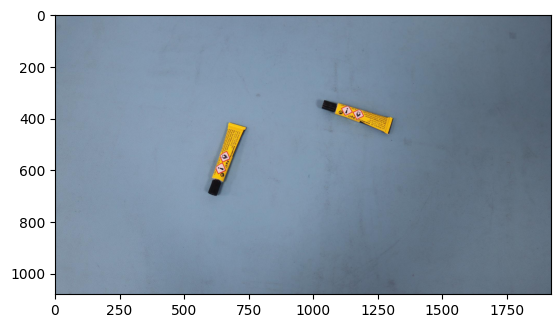

In [73]:
output_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

keypoints = predictions[0]['keypoints'].detach().cpu().numpy()
boxes = predictions[0]['boxes'].detach().cpu().numpy()

for i in range(len(predictions[0]['scores'])):
    if predictions[0]['scores'][i] > 0.5:
        cv2.rectangle(output_image, (int(boxes[i][0]), int(boxes[i][1])), (int(boxes[i][2]), int(boxes[i][3])), (0, 255, 0), 2)
        for j in range(len(keypoints[i])):
            cv2.circle(output_image, (int(keypoints[i][j][0]), int(keypoints[i][j][1])), 2, (0, 0, 255), 2)
# imshow
plt.imshow(output_image)
plt.show()